In [6]:
pip install prophet xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 1.6/124.9 MB 4.4 MB/s eta 0:00:28
    --------------------------------------- 2.4/124.9 MB 4.2 MB/s eta 0:00:30
   - -------------------------------------- 3.4/124.9 MB 4.3 MB/s eta 0:00:29
   - -------------------------------------- 4.2/124.9 MB 4.3 MB/s eta 0:00:28
   - -------------------------------------- 5.2/124.9 MB 4.4 MB/s eta 0:00:28
   - -------------------------------------- 6.0/124.9 MB 4.4 MB/s eta 0:00:28
   -- ------------------------------------- 6.8/124.9 MB 4.4 MB/s eta 0:00:28
   -- ------------------------------------- 7.9/124.9 MB 4.4 MB/s eta 0:00:27
   -- ------------------------------------- 8.7/124.9 MB 4.4 MB/s eta 0:00:27
   --- ------------------------------------ 9.7/124.9 MB 4.4 MB/s eta 0:00:27
   --- ------------------------------------ 10.5/124.9 MB 4.4 MB/s eta 

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
def prepare_data(df):
    """
    Prepare the data for modeling by creating necessary features and encoding
    """
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
    # Create copy of DataFrame with date as column for Prophet
    df = df.copy()
    df['date'] = df.index
    
    # Create time-based features
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    
    # Create seasonality features
    df['quarter'] = df.index.quarter
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # One-hot encode day_of_week if it exists as categorical
    if 'day_of_week' in df.columns and df['day_of_week'].dtype == 'O':
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        day_of_week_encoded = encoder.fit_transform(df[['day_of_week']])
        day_of_week_cols = [f'day_{i}' for i in range(day_of_week_encoded.shape[1])]
        df[day_of_week_cols] = day_of_week_encoded
        df.drop('day_of_week', axis=1, inplace=True)
        
    # Convert is_holiday to numeric if it isn't already
    if 'is_holiday' in df.columns and df['is_holiday'].dtype == 'O':
        df['is_holiday'] = df['is_holiday'].astype(int)
    return df

In [3]:
def create_recurring_holidays(df):
    """
    Create a DataFrame of recurring holidays from historical data
    """
    # Get dates that are holidays
    holiday_dates = df[df['is_holiday'] == 1]['date']
    # Extract month and day for each holiday
    holiday_patterns = pd.DataFrame({
    'month': holiday_dates.dt.month,
    'day': holiday_dates.dt.day
    }).drop_duplicates()
    # Create holidays for the forecast period
    last_date = df.index.max()
    forecast_end = last_date + pd.DateOffset(months=4) # Add buffer for forecast period
    all_holidays = []
    for year in range(df.index.min().year, forecast_end.year + 1):
        for _, holiday in holiday_patterns.iterrows():
            try:
                holiday_date = pd.Timestamp(year=year, month=holiday['month'], day=holiday['day'])
                all_holidays.append(holiday_date)
            except ValueError:
                continue # Skip invalid dates (e.g., Feb 29 in non-leap years)
    holidays_df = pd.DataFrame({
        'ds': all_holidays,
        'holiday': 'recurring_holiday',
        'lower_window': 0,
        'upper_window': 0
        })
    return holidays_df

In [4]:
def train_prophet_model(df):
    """
    Train a Prophet model with enhanced seasonality
    """
    # Prepare data for Prophet
    prophet_df = df[['date', 'total_calls']].rename(columns={
        'date': 'ds',
        'total_calls': 'y'
        })
    # Create holidays DataFrame
    if 'is_holiday' in df.columns:
        holidays_df = create_recurring_holidays(df)
    else:
        holidays_df = None
    # Initialize Prophet with detailed seasonality
    model = Prophet(
        yearly_seasonality=20, # More complex yearly seasonality
        weekly_seasonality=7, # Detailed weekly patterns
        daily_seasonality=True,
        holidays=holidays_df, # Add our recurring holidays
        holidays_prior_scale=10, # Increase impact of holidays
        seasonality_prior_scale=10,
        seasonality_mode='multiplicative' # Often better for call center data
    )
    # Add custom seasonalities
    model.add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=5
    )
    model.fit(prophet_df)
    return model

In [16]:
def train_xgboost_model(df):
    """
    Train an XGBoost model using all relevant features
    """
    # Prepare features - including all potentially important features
    feature_cols = [
        # Time-based features
        'month', 'year', 'day_of_month', 'week_of_year',
        'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
        'quarter', 'is_holiday',
        # Operational features
        'number_of_unique_logins',
        'working_time',
        # Call metrics
        'answered_calls',
        'missed_calls',
        'unique_numbers',
        'Call duration',
        'time_to_next_call',
        'calls_from_clients',
        'share_of_answered_calls',
        'share_of_calls_from_registered_number',
        # Client metrics
        'number_of_new_clients',
        'number_of_new_clients_last_7_days',
        'number_of_new_clients_last_30_days',
        'clients_count'
    ]
    # Remove any features that don't exist in the dataset
    feature_cols = [col for col in feature_cols if col in df.columns]
    print(feature_cols, 'feature_cols')
    # Check for categorical columns and handle accordingly
    categorical_features = []
    for col in feature_cols:
        if df[col].dtype == 'object' or df[col].dtype == 'bool':
            categorical_features.append(col)
    
    # Create feature matrix X
    X = df[feature_cols].copy()
    # Convert boolean/categorical columns to numeric
    for col in categorical_features:
        X[col] = X[col].astype(int)
    y = df['total_calls']
    # Train XGBoost with parameters tuned for time series
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X, y)
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    return model, feature_cols

In [17]:
def generate_future_dates(last_date, periods):
    """
    Generate future dates for prediction
    """
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=periods,
        freq='D'
    )
    return future_dates

In [18]:
def make_predictions(df, forecast_days=90):
    """
    Make predictions using both Prophet and XGBoost models
    """
    # Prepare data with enhanced features
    df_prepared = prepare_data(df)
    
    # Train Prophet model
    prophet_model = train_prophet_model(df_prepared)
    
    # Generate future dates for Prophet
    future_dates = generate_future_dates(df_prepared['date'].max(), forecast_days)
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Make Prophet predictions
    prophet_forecast = prophet_model.predict(future_df)
    
    # Train XGBoost model
    xgb_model, feature_cols = train_xgboost_model(df_prepared)
    
    # Prepare future data for XGBoost
    future_features = pd.DataFrame(index=future_dates)
    future_features['date'] = future_dates
    future_features['month'] = future_dates.month
    future_features['year'] = future_dates.year
    future_features['day_of_month'] = future_dates.day
    future_features['week_of_year'] = future_dates.isocalendar().week
    future_features['quarter'] = future_dates.quarter
    future_features['month_sin'] = np.sin(2 * np.pi * future_dates.month / 12)
    future_features['month_cos'] = np.cos(2 * np.pi * future_dates.month / 12)
    future_features['day_of_week_sin'] = np.sin(2 * np.pi * future_dates.dayofweek / 7)
    future_features['day_of_week_cos'] = np.cos(2 * np.pi * future_dates.dayofweek / 7)
    
    # Add holiday information if available
    if 'is_holiday' in df.columns:
        future_features['is_holiday'] = 0 # Default to non-holiday
    # Add other features if available
    if 'number_of_unique_logins' in df.columns:
        future_features['number_of_unique_logins'] = df_prepared['number_of_unique_logins'].mean()
    if 'working_time' in df.columns:
        future_features['working_time'] = df_prepared['working_time'].mean()
    
    # Add one-hot encoded day of week if present in training data
    day_cols = [col for col in feature_cols if col.startswith('day_') and col != 'day_of_month']
    if day_cols:
        for col in day_cols:
            future_features[col] = 0
        for i, date in enumerate(future_dates):
            day_num = date.dayofweek
            if f'day_{day_num}' in day_cols:
                future_features.loc[future_features.index[i], f'day_{day_num}'] = 1
    
    # Make XGBoost predictions
    xgb_forecast = xgb_model.predict(future_features[feature_cols])
    
    # Combine predictions with weighted ensemble
    # Give more weight to Prophet for longer-term predictions
    weights = np.linspace(0.4, 0.6, forecast_days) # Gradually increase Prophet's weight
    final_forecast = pd.DataFrame({
        'date': future_dates,
        'prophet_forecast': prophet_forecast['yhat'],
        'xgboost_forecast': xgb_forecast,
        'ensemble_forecast': weights * prophet_forecast['yhat'] + (1 - weights) * xgb_forecast
    })
    return final_forecast

In [19]:
def evaluate_models(df):
    """
    Evaluate model performance using historical data
    """
    # Use last 30 days as test set
    test_size = 30
    train_df = df[:-test_size]
    test_df = df[-test_size:]
    
    # Make predictions
    forecast = make_predictions(train_df, forecast_days=test_size)
    
    # Calculate metrics
    actual_values = test_df['total_calls'].values
    predicted_values = forecast['ensemble_forecast'].values
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    return mae, rmse, mape

In [20]:
# Load data
df = pd.read_excel('calls.xlsx', parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df = df.drop(columns=['Unnamed: 0'])

In [21]:
df["day_of_week"] = df.index.day_name()

In [22]:
# Define Armenian holidays 
armenian_holidays = [
'2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01',
'2022-01-02','2023-01-02','2024-01-02','2025-01-02','2026-01-02',
'2022-01-06','2023-01-06','2024-01-06','2025-01-06','2026-01-06',
'2022-01-28','2023-01-28','2024-01-28','2025-01-28','2026-01-28',
'2022-03-08','2023-03-08','2024-03-08','2025-03-08','2026-03-08',
'2022-04-24','2023-04-24','2024-04-24','2025-04-24','2026-04-24',
'2022-05-01','2023-05-01','2024-05-01','2025-05-01','2026-05-01',
'2022-05-09','2023-05-09','2024-05-09','2025-05-09','2026-05-09',
'2022-05-28','2023-05-28','2024-05-28','2025-05-28','2026-05-28',
'2022-07-05','2023-07-05','2024-07-05','2025-07-05','2026-07-05',
'2022-09-21','2023-09-21','2024-09-21','2025-09-21','2026-09-21',
'2022-12-31','2023-12-31','2024-12-31','2025-12-31','2026-12-31',
]
armenian_holidays = pd.to_datetime(armenian_holidays)
# Add a column to indicate if the date is a holiday
df["is_holiday"] = df.index.isin(armenian_holidays)

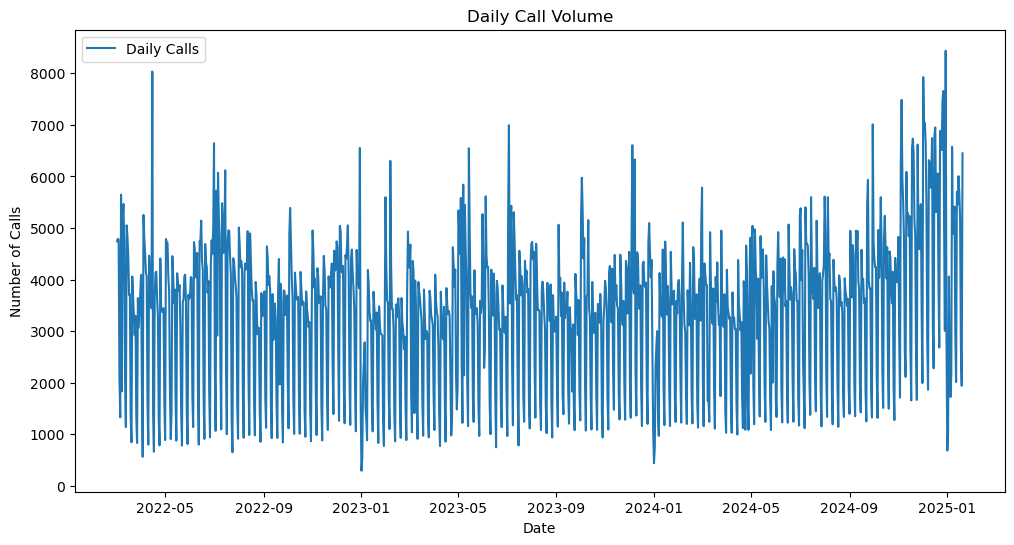

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df['total_calls'], label='Daily Calls')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [24]:
df.index = pd.to_datetime(df.index)

In [25]:
df.tail(10)

,answered_calls,missed_calls,unique_numbers,Call duration,time_to_next_call,number_of_unique_logins,working_time,calls_from_clients,total_calls,share_of_answered_calls,share_of_calls_from_registered_number,number_of_new_clients,number_of_new_clients_last_7_days,number_of_new_clients_last_30_days,clients,day_of_week,is_holiday
Date,,,,,,,,,,,,,,,,,
2025-01-11,2218,767,2352,2.473999,3.443789,32,6.732474,2421.0,2985,0.743049,0.811055,279,2381,34847,609702,Saturday,False
2025-01-12,1306,707,1523,2.818291,4.104140,20,7.396903,1574.0,2013,0.648783,0.781918,266,2522,33359,609950,Sunday,False
2025-01-13,3996,1705,4067,2.832494,3.038536,57,6.763124,4757.0,5701,0.700930,0.834415,469,2822,32292,610352,Monday,False
2025-01-14,3853,1600,3953,2.797225,2.997986,55,6.659556,4323.0,5453,0.706584,0.792775,373,2783,31670,610627,Tuesday,False
2025-01-15,4268,1736,4317,2.737904,2.981088,58,6.904646,4871.0,6004,0.710859,0.811292,342,2637,30266,610507,Wednesday,False
2025-01-16,4409,1267,4175,2.722432,2.883531,60,6.752829,4591.0,5676,0.776779,0.808844,440,2603,28776,609741,Thursday,False
2025-01-17,4165,1010,3863,2.735156,3.085816,60,6.613079,4120.0,5175,0.804831,0.796135,440,2609,27284,610109,Friday,False
2025-01-18,1607,1092,2037,2.734610,3.945288,30,5.859130,2164.0,2699,0.595406,0.801778,123,2453,25496,610217,Saturday,False
2025-01-19,1578,362,1554,2.832519,3.962918,24,7.321644,1587.0,1940,0.813402,0.818041,163,2350,24180,610366,Sunday,False


In [26]:
# Assuming your data is in a pandas DataFrame called 'df' with a datetime index
results = make_predictions(df, forecast_days=90)
mae, rmse, mape = evaluate_models(df)
print(f"Model Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

17:05:21 - cmdstanpy - INFO - Chain [1] start processing
17:05:21 - cmdstanpy - INFO - Chain [1] done processing


['month', 'year', 'day_of_month', 'week_of_year', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter', 'is_holiday', 'number_of_unique_logins', 'working_time', 'answered_calls', 'missed_calls', 'unique_numbers', 'Call duration', 'time_to_next_call', 'calls_from_clients', 'share_of_answered_calls', 'share_of_calls_from_registered_number', 'number_of_new_clients', 'number_of_new_clients_last_7_days', 'number_of_new_clients_last_30_days'] feature_cols

Top 10 Most Important Features:
                                  feature  importance
17                     calls_from_clients    0.625884
14                         unique_numbers    0.328571
13                           missed_calls    0.021724
19  share_of_calls_from_registered_number    0.006892
18                share_of_answered_calls    0.006758
6                         day_of_week_sin    0.001550
4                               month_sin    0.001454
20                  number_of_new_clients    0.001277
11    

KeyError: "['answered_calls', 'missed_calls', 'unique_numbers', 'Call duration', 'time_to_next_call', 'calls_from_clients', 'share_of_answered_calls', 'share_of_calls_from_registered_number', 'number_of_new_clients', 'number_of_new_clients_last_7_days', 'number_of_new_clients_last_30_days'] not in index"

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(results['date'], results['ensemble_forecast'], label='Forecast')
plt.title('Call Center 90-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results' is not defined

<Figure size 1500x700 with 0 Axes>